# Teaching Demo — 

Bill Quinn
May 10, 2022

## Goals

1. 

## Suggested 

## Overview

1. Load necessary libraries.

### Importing Libraries

In [1]:
import constellate
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt

Constellate: use and download of datasets is covered by the Terms & Conditions of Use: https://constellate.org/terms-and-conditions/


### Importing Data from Constellate

In [2]:
%%time

dataset_id = '7e41317e-740f-e86a-4729-20dab492e925'

dataset_file = constellate.download(dataset_id, 'jsonl')

All documents from JSTOR published in Shakespeare Quarterly from 1950 - 2020. 6745 documents.
INFO:root:File /Users/williamquinn/data/7e41317e-740f-e86a-4729-20dab492e925.jsonl.gz exists. Not re-downloading.
CPU times: user 28.8 ms, sys: 14.1 ms, total: 42.9 ms
Wall time: 538 ms


#### Create functions for cleaning data

In [3]:
%%time

# Define a function that will process individual tokens
# Only a token that passes through all three `if` 
# statements will be returned. A `True` result for
# any `if` statement does not return the token. 
def process_token(token):
    token = token.lower()
    if len(token) < 4: # If True, do not return token
        return None
    if not(token.isalpha()): # If True, do not return token
        return None
    return token # If all are False, return the lowercased token

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 11.9 µs


In [4]:
%%time

# Create an empty list to hold documents.
dataframe = []

# Loop through each document.
for document in constellate.dataset_reader(dataset_file):
    
    doc_data = {} # Create an empty dictionary to hold all information about a single document.
    
    doc_data['id'] = document['id'] # Add key and value the document's id to dataframe dictionary.
    doc_data['title'] = document['title']
    doc_data['publisher'] = document['publisher']
    doc_data['publicationYear'] = document['publicationYear']
    
#     Keep data if the publicationYear is later than 1990 and the article isn't a review.
    if document['publicationYear'] >= 1990 and doc_data['title'] != 'Review Article':
        
        processed_document = []
        unigrams = document.get('unigramCount', [])
        for gram, count in unigrams.items():
            clean_gram = process_token(gram)
            if clean_gram is None:
                continue

            processed_document += [clean_gram] * count 

        doc_data['text'] = processed_document # Add text to dictionary.

        dataframe.append(doc_data) # Append document dictionary to dataframe list.
    
#     Otherwise, ignore and pass to the next.
    else:
        pass
        
# Convert list of dictionaries to dataframe.     
dataframe = pd.DataFrame(dataframe)

# Convert list of unigrams in the 'text' field to string.
dataframe['text'] = dataframe['text'].apply(lambda x: ' '.join(x))

dataframe.head()

CPU times: user 36.9 s, sys: 2.14 s, total: 39 s
Wall time: 39.2 s


,id,title,publisher,publicationYear,text
0,http://www.jstor.org/stable/24778460,"""The Killing Stops Here"": Unmaking the Myths o...",Folger Shakespeare Library,2013,killing stops unmaking myths troy troy wooster...
1,http://www.jstor.org/stable/2870867,The Shenandoah Shakespeare Express,Folger Shakespeare Library,1992,shakespeare shakespeare shakespeare shakespear...
2,http://www.jstor.org/stable/2871295,Retrieving Jonson's Petrarch,Folger Shakespeare Library,1994,retrieving petrarch petrarch petrarch petrarch...
3,http://www.jstor.org/stable/3844072,"Shakescorp ""Noir""",Folger Shakespeare Library,2002,shakescorp noir douglas douglas lanier lanier ...
4,http://www.jstor.org/stable/2871279,Glass Slippers and Seven-League Boots: C-Promp...,Folger Shakespeare Library,1997,glass slippers doubts about ascribing funeral ...


In [5]:
dataset_file

'/Users/williamquinn/data/7e41317e-740f-e86a-4729-20dab492e925.jsonl.gz'

#### Examine Document Metadata Fields

In [6]:
%%time

print ('"Keys" of Each Document')
for k in document.keys():
    print ('\t-', k)

"Keys" of Each Document
	- id
	- docType
	- title
	- creator
	- isPartOf
	- sourceCategory
	- pageStart
	- url
	- volumeNumber
	- issueNumber
	- language
	- pageEnd
	- pageCount
	- pagination
	- datePublished
	- publicationYear
	- publisher
	- wordCount
	- provider
	- outputFormat
	- identifier
	- unigramCount
	- bigramCount
	- trigramCount
CPU times: user 1.81 ms, sys: 1.25 ms, total: 3.07 ms
Wall time: 4.97 ms


## Find TF-IDF of Documents

In [7]:
%%time

# Instantiate a vectorizer. 
tfidf = TfidfVectorizer(
    min_df=0.05, 
    max_df=0.9,
    stop_words='english',
    encoding='latin-1'
)

# The features are a matrix.
features = tfidf.fit_transform(dataframe['text']).toarray()

# Show data size.
print (features.shape)

(938, 5669)
CPU times: user 3.56 s, sys: 97.6 ms, total: 3.66 s
Wall time: 3.68 s


## Preparing the Data

We are trying to create a matrix: rows and columns with numerical values. More specifically, each row of this matrix will represent a document and the columns will represent the frequency (TF-IDF) of a specific word. We can achieve this transformation by separating out our metadata and then re-shaping the dataframe. Many computational processes expect a matrix-like input. The following code-block, then, can be a useful reference for other projects as well.

In [8]:
%%time


doc_data = pd.DataFrame(features,
                        index = dataframe.index,
                        columns = tfidf.get_feature_names())

doc_data.head(3)

CPU times: user 8.32 ms, sys: 373 µs, total: 8.7 ms
Wall time: 9.22 ms


,aaron,abandon,abandoned,ability,able,ably,abraham,absence,absent,absolute,...,years,yellow,yield,yields,york,yorkshire,young,younger,youth,youthful
0,0.0,0.0,0.0,0.000000,0.022407,0.021964,0.0,0.000000,0.000000,0.0,...,0.029897,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.018231,0.000000,0.000000,0.0,0.000000,0.023387,0.0,...,0.013681,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.038370,0.032371,0.000000,0.0,0.038306,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.094244,0.0,0.0,0.0,0.0,0.0


#### Re-Join Features with Metadata

In [9]:
%%time

dataframe = dataframe \
    .drop(columns = ['text']) \
    .merge(doc_data, left_index=True, right_index=True, how = 'inner')

dataframe.head(3)

CPU times: user 51.2 ms, sys: 19.8 ms, total: 71 ms
Wall time: 70.9 ms


,id,title_x,publisher_x,publicationYear,aaron,abandon,abandoned,ability,able,ably,...,years,yellow,yield,yields,york,yorkshire,young,younger,youth,youthful
0,http://www.jstor.org/stable/24778460,"""The Killing Stops Here"": Unmaking the Myths o...",Folger Shakespeare Library,2013,0.0,0.0,0.0,0.000000,0.022407,0.021964,...,0.029897,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,http://www.jstor.org/stable/2870867,The Shenandoah Shakespeare Express,Folger Shakespeare Library,1992,0.0,0.0,0.0,0.018231,0.000000,0.000000,...,0.013681,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,http://www.jstor.org/stable/2871295,Retrieving Jonson's Petrarch,Folger Shakespeare Library,1994,0.0,0.0,0.0,0.038370,0.032371,0.000000,...,0.000000,0.0,0.0,0.0,0.094244,0.0,0.0,0.0,0.0,0.0


When merging the two dataframes (features and metadata), pandas found two columns with the same name: title. One refers to the metadata, the title of the article. The other refers to the word "title" as it appears within the article. Pandas distinguishes between the two by adding "_x" to the first.

In [10]:
%%time

# Rename column for clarity.
dataframe = dataframe.rename(columns = {'title_x': 'meta_title', 'publisher_x': 'meta_publisher'})

dataframe.head(2)

CPU times: user 26.2 ms, sys: 19.9 ms, total: 46.2 ms
Wall time: 45.3 ms


,id,meta_title,meta_publisher,publicationYear,aaron,abandon,abandoned,ability,able,ably,...,years,yellow,yield,yields,york,yorkshire,young,younger,youth,youthful
0,http://www.jstor.org/stable/24778460,"""The Killing Stops Here"": Unmaking the Myths o...",Folger Shakespeare Library,2013,0.0,0.0,0.0,0.000000,0.022407,0.021964,...,0.029897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,http://www.jstor.org/stable/2870867,The Shenandoah Shakespeare Express,Folger Shakespeare Library,1992,0.0,0.0,0.0,0.018231,0.000000,0.000000,...,0.013681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Scale Data

In [11]:
%%time

# Overwrite features data with scaled version.
features = StandardScaler().fit_transform(features)

CPU times: user 117 ms, sys: 29.4 ms, total: 146 ms
Wall time: 149 ms


## Principal Component Analysis

In [12]:
%%time

pca = PCA(n_components = 2)

components = pca.fit_transform(features)

pcaDF = pd.DataFrame(data = components, 
                           columns = ['pc1', 'pc2'],
                           index = dataframe.index)

pcaDF.head()

CPU times: user 582 ms, sys: 63.2 ms, total: 645 ms
Wall time: 363 ms


,pc1,pc2
0,9.249441,5.596426
1,5.574416,9.927012
2,-1.292714,2.182032
3,10.189810,-4.105640
4,5.923143,0.805288


### Visualize

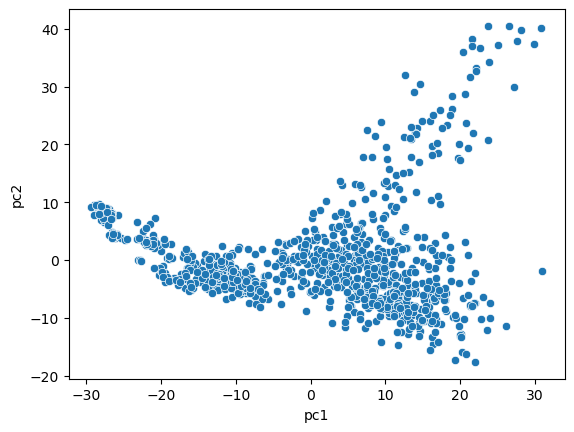

CPU times: user 267 ms, sys: 26.6 ms, total: 294 ms
Wall time: 271 ms


In [13]:
%%time

sns.scatterplot(
    data = pcaDF,
    x = 'pc1', y = 'pc2'
)

plt.show()

## Clustering

What is clustering?

In [14]:
%%time

model = KMeans(n_clusters = 5, random_state = 0) 

predictions = model.fit_predict(components)

pcaDF['meta_cluster'] = predictions
pcaDF['meta_publisher'] = dataframe['meta_publisher']

CPU times: user 334 ms, sys: 29.2 ms, total: 363 ms
Wall time: 120 ms


#### Append Cluster Labels to Dataframe

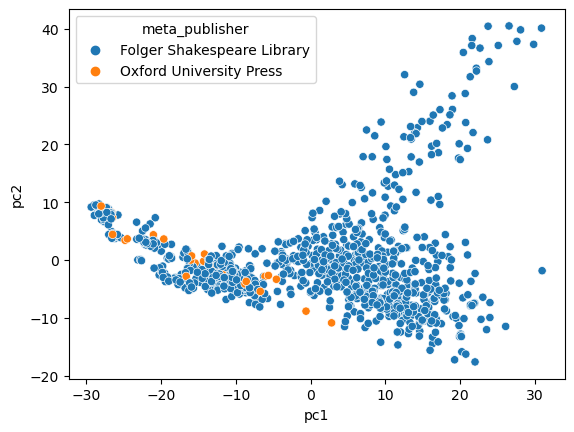

CPU times: user 780 ms, sys: 37.8 ms, total: 818 ms
Wall time: 333 ms


In [15]:
%%time

# Seaborn will read the labels as numerical and apply a gradient color scheme.
# Instead, we want to treat the labels as categorical, so we will change them from integers to strings.
pcaDF['meta_cluster'] = pcaDF['meta_cluster'].astype(str)

sns.scatterplot(
    data = pcaDF,
    x = 'pc1', y = 'pc2',
    hue = 'meta_publisher'
)

plt.show()